In [90]:
%matplotlib inline 
import matplotlib.pylab as plt
import pandas as pd 
import numpy as np 
import pickle
import datetime as dt
import matplotlib.cm as cm
import random
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 15, 9

# Create Dataset

In [91]:
# # Get Rain Data
# path = '../datastore/'
# w = pd.read_csv(path + 'weather-2-23-to3-3-s3.0.csv',  usecols=['DATE', 'rain'] )
# w.index = pd.to_datetime(w['DATE'].values, format='%Y%m%d')
# del w['DATE']
# w = w/10 # convert to 10*cm
# w.rain.plot()

In [92]:
# List available parking data
ls '../datastore/paystations/'

SyntaxError: invalid syntax (<ipython-input-92-9f4e26ec3ea3>, line 2)

In [93]:
# Get Parking Data
path = '../datastore/paystations/'
f = '8005_374_days.d' 
key = f.split('_')[0]
data = pickle.load(open(path + f, 'rb'))

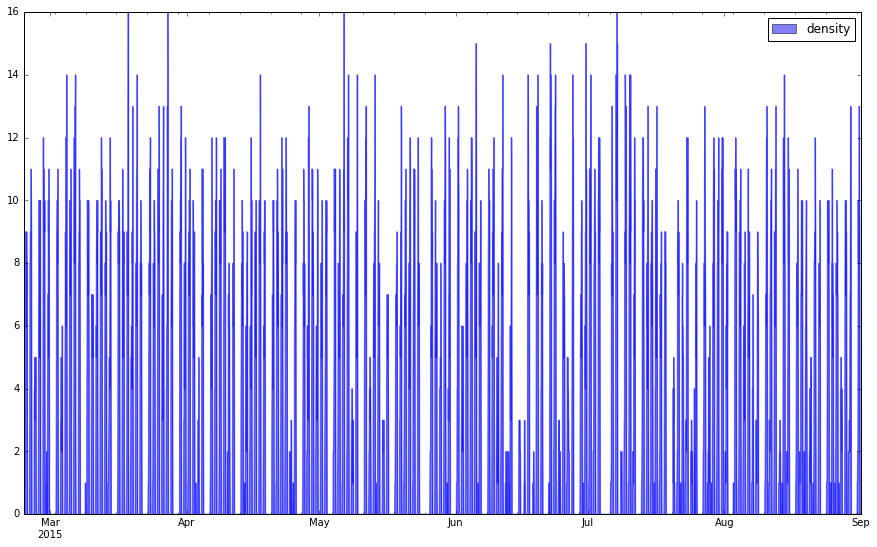

In [137]:
start_day = '2-23-2015'
end_day = '3-3-2016'
start = pd.to_datetime(start_day, format='%m-%d-%Y')
end = pd.to_datetime(end_day, format='%m-%d-%Y')
start2 = pd.to_datetime('3-19-2015', format='%m-%d-%Y')
end2 = pd.to_datetime('9-1-2015', format='%m-%d-%Y') # rain

# make timeseries dataframe
ts = pd.DataFrame(data.flatten(), columns=['density']) 
ts.index = pd.date_range(start, end, freq='H')[0:-1]
ts = ts.dropna()
ts = ts[start:end2]

# # Concat rain data(starts 3-19)
# w = w.resample('H', fill_method='pad') # upsample to hourly
# w.fillna(0)
# ts = pd.concat([ts, w], axis=1)

# Show
ts.plot(legend=True, kind='area', stacked=False)
# # ts.to_csv('parking.csv')

# Create Features
Possible Features:
1. density
2. time
3. day
3. month
4. coordinates
5. weather
6. Traffic



In [138]:
# Define Features (X) and Predict
# # cols = ['density', 'month', 'day', 'time', 'lat', 'long', 'weather']
X = pd.DataFrame()

# Generate features
X['month'] = ts.index.month
# X['day'] = ts.index.day
X['weekday'] = ts.index.weekday
X['hour'] = ts.index.hour
# X['rain'] = ts['rain'].values
Y = ts['density']
X.index = ts.index
Y.index = ts.index


# Train and Predict

In [139]:
# Train (80%) Test (20%) Random
# rows = random.sample(X.index, int(len(ts)*.80))
# x_train, y_train = X.ix[rows],Y.ix[rows]
# x_test, y_test  = X.drop(rows),Y.drop(rows)

In [149]:
# Split training and test data
predict_days = 7 # N, how many days to predict

n_days = (X.index[-1] - X.index[0]).days
percent_train = predict_days/float(n_days)
split_i = int(len(ts)*(1-percent_train))
x_train, y_train = X.ix[0:split_i-1],Y.ix[0:split_i-1]
x_test, y_test  = X.ix[split_i:len(ts)],Y.ix[split_i:len(ts)]

In [150]:
# Run Model
params = {'n_estimators': 200, 'max_depth': 6,
        'learning_rate': 0.1, 'loss': 'huber','alpha':0.95}
clf = GradientBoostingRegressor(**params).fit(x_train, y_train)

# Results

In [151]:
# Check Error
mse = mean_squared_error(y_test, clf.predict(x_test))
r2 = r2_score(y_test, clf.predict(x_test))
print("MSE: %.4f" % mse)
print("Mean Error (R2): %.4f cars" % r2)
# minimize one of these errors


MSE: 1.7798
Mean Error (R2): 0.8688 cars


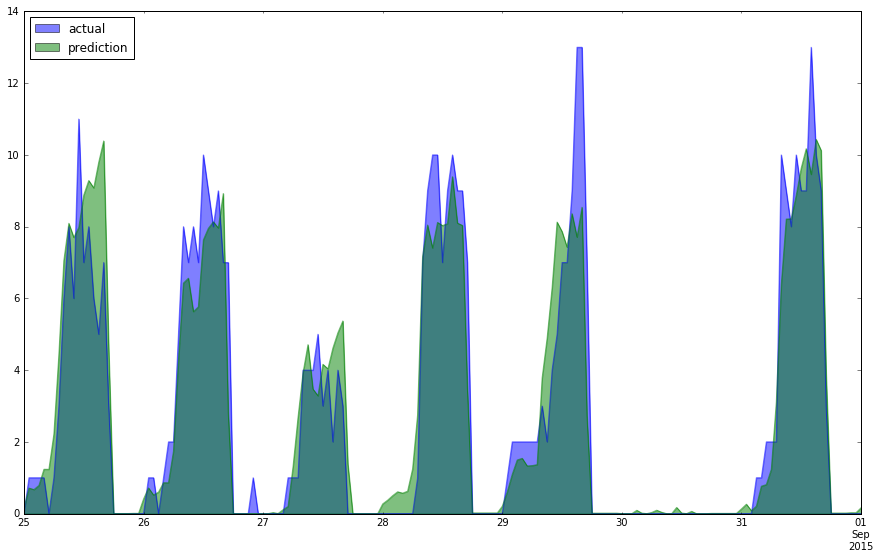

In [152]:
y_pred = pd.DataFrame(clf.predict(x_test), index = x_test.index, columns=['prediction'])
y_pred[y_pred < 0] = 0
ax = y_test.plot(legend=True, label = 'actual', kind='area', stacked=False)
y_pred.plot(ax=ax, kind='area', stacked=False)

/usr/local/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function staged_decision_function is deprecated;  and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


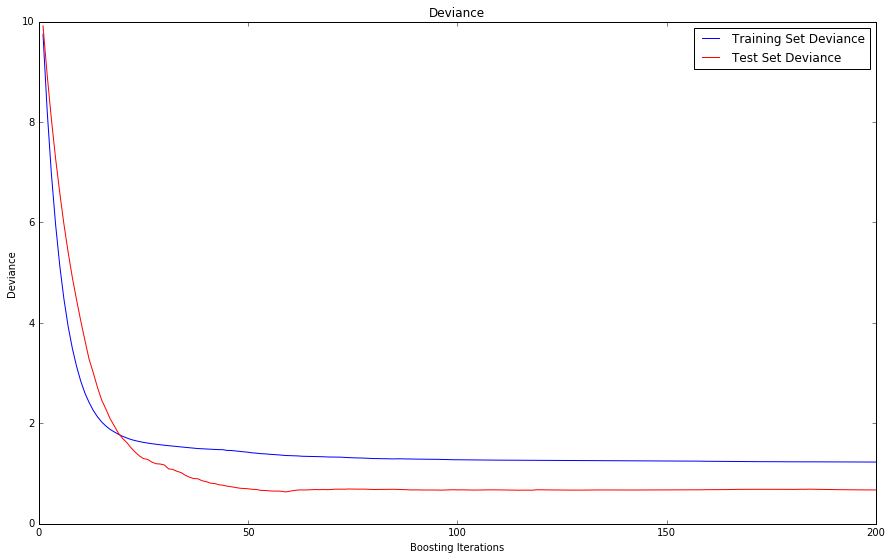

In [145]:
# Compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
 
for i, y_pred in enumerate(clf.staged_decision_function(x_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

# Plot
plt.figure()
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
                label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
                label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')


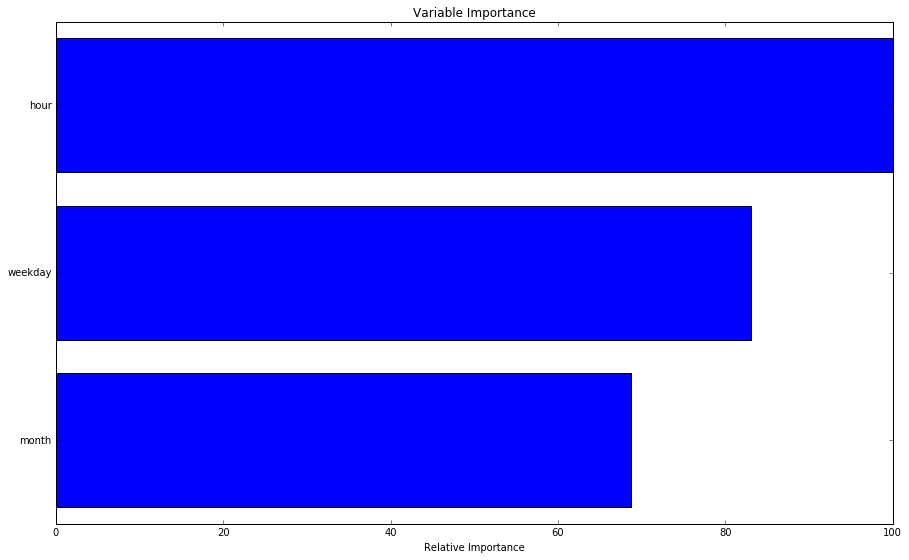

In [146]:
# Feature importance

feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure()
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

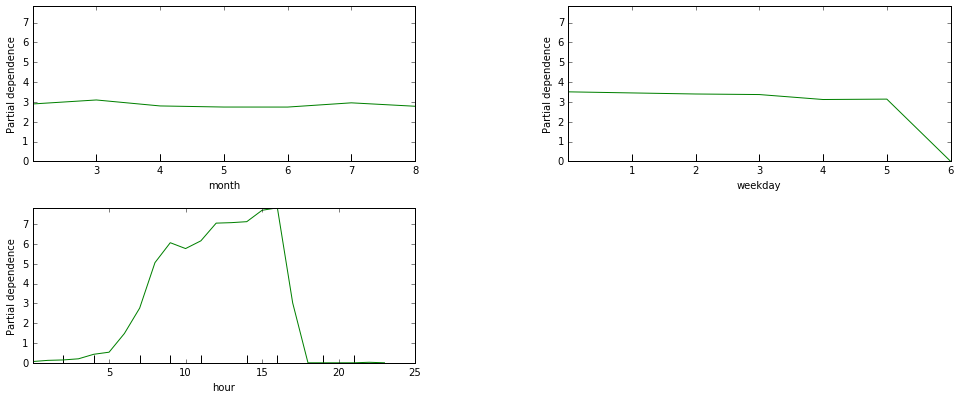

In [147]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

plot_partial_dependence(clf, 
                        x_train, 
                        features=np.arange(0,len(X.columns)),
                        feature_names=x_train.columns, n_cols=2
                       )
 
    
plt.show()